In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import time
import sklearn
import scipy

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix

In [3]:
heart = pd.read_csv('FinalHeart.csv')
heart.drop(['Unnamed: 0'],axis=1,inplace=True)
heart.head(3)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0.0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2.0
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1.0


In [4]:
from sklearn.tree import DecisionTreeClassifier

In [5]:
dtc = DecisionTreeClassifier()

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
X = heart.drop(['num'],axis=1).copy()
Y = heart.num.copy()

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size= 0.33, stratify=Y)

In [9]:
dtc.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [10]:
dtc = DecisionTreeClassifier()
dtc.set_params( random_state = 144)
%time dtc.fit(X_train, Y_train)
r2_train = np.round(dtc.score(X_train, Y_train),3)
r2_test  = np.round(dtc.score(X_test, Y_test),3)
print('Train score is :' + str(r2_train))
print('Test score is :' + str(r2_test))

CPU times: total: 0 ns
Wall time: 4 ms
Train score is :1.0
Test score is :0.609


In [11]:
criterion      = ['gini','entropy','log_loss']
max_depth      = np.arange(1,80, 5)
max_features   = np.arange(1,14,2)
min_samples_split = np.arange(2,20,2)

In [12]:
import warnings
warnings.filterwarnings('ignore')

In [13]:
dtc = DecisionTreeClassifier()
dtc.set_params( random_state = 144)

param_grid = {'criterion':criterion, 'max_depth':max_depth, 'max_features':max_features,
              'min_samples_split':min_samples_split}

dtc_grid = GridSearchCV(dtc, param_grid, cv = 3, return_train_score=True)
%time dtc_grid.fit(X_train, Y_train)

CPU times: total: 34.5 s
Wall time: 34.6 s


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=144),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': array([ 1,  6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71, 76]),
                         'max_features': array([ 1,  3,  5,  7,  9, 11, 13]),
                         'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18])},
             return_train_score=True)

In [14]:
dtc_df = pd.DataFrame(dtc_grid.cv_results_)
dtc_df.shape

(3024, 20)

In [15]:
dtc_df.dropna(axis = 0, how = 'any', inplace=True)

In [16]:
dtc_df.shape

(2016, 20)

In [17]:
dtc_final_df = dtc_df.loc[:,['param_criterion','param_max_depth','param_max_features',
                            'param_min_samples_split','mean_train_score','mean_test_score']]

In [18]:
dtc_final_df['diff'] = abs(dtc_final_df['mean_train_score']-dtc_final_df['mean_test_score'])

In [19]:
dtc_final_df.to_csv('DecisionTree.csv')

In [20]:
print('Training score is :' + str(np.round(dtc_grid.best_estimator_.score(X_train, Y_train),2)))
print('Testing  score is :' + str(np.round(dtc_grid.best_estimator_.score(X_test, Y_test),2)))

Training score is :0.75
Testing  score is :0.66


In [21]:
dtc_final_df.sort_values(by='diff', ascending = False).iloc[850:,:]

,param_criterion,param_max_depth,param_max_features,param_min_samples_split,mean_train_score,mean_test_score,diff
428,gini,31,11,12,0.810169,0.556004,0.254165
932,gini,71,11,12,0.810169,0.556004,0.254165
302,gini,21,11,12,0.810169,0.556004,0.254165
1462,entropy,36,3,10,0.791516,0.537384,0.254132
1588,entropy,46,3,10,0.791516,0.537384,0.254132
...,...,...,...,...,...,...,...
1011,entropy,1,1,8,0.500003,0.500013,0.000010
1012,entropy,1,1,10,0.500003,0.500013,0.000010
1013,entropy,1,1,12,0.500003,0.500013,0.000010
1014,entropy,1,1,14,0.500003,0.500013,0.000010


In [23]:
#final decision tree model
dtc = DecisionTreeClassifier()
dtc.set_params(criterion = 'entropy', max_depth = 3, max_features = 5, min_samples_split = 12, random_state = 144)
dtc.fit(X_train, Y_train)

r2_train = np.round(dtc.score(X_train, Y_train),3)
r2_test  = np.round(dtc.score(X_test, Y_test),3)

print('Train score is :' + str(r2_train))
print('Test score is :' + str(r2_test))

Train score is :0.635
Test score is :0.634


In [24]:
Y_train_pred = dtc.predict(X_train)
Y_test_pred = dtc.predict(X_test)

In [25]:
conf_data_train = confusion_matrix(Y_train,Y_train_pred)
conf_data_test  = confusion_matrix(Y_test,Y_test_pred)

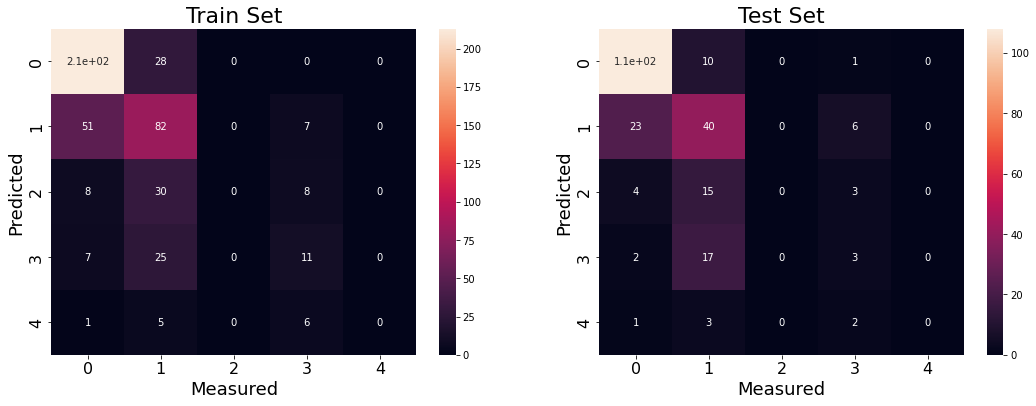

In [26]:
fig, ax = plt.subplots(1,2,figsize= (18,6))
sns.heatmap(conf_data_train, ax = ax[0], annot=True)
sns.heatmap(conf_data_test,  ax = ax[1], annot=True)

ax[0].tick_params(axis='both',labelsize=16)
ax[0].set_xlabel('Measured', fontsize= 18)
ax[0].set_ylabel('Predicted', fontsize= 18)
ax[0].set_title('Train Set',fontsize= 22)

ax[1].tick_params(axis='both',labelsize=16)
ax[1].set_xlabel('Measured', fontsize= 18)
ax[1].set_ylabel('Predicted', fontsize= 18)
ax[1].set_title('Test Set',fontsize= 22);

In [27]:
conf_train_norm = np.zeros_like(conf_data_train, dtype=float)
conf_test_norm = np.zeros_like(conf_data_test, dtype=float)

sum_vec_train = np.sum(conf_data_train, axis = 1)
sum_vec_test  = np.sum(conf_data_test , axis = 1)

print('*'*100)

for irow in range(conf_train_norm.shape[0]):
    
    conf_train_norm[irow,:] = 100 * np.round(conf_data_train[irow,:]/sum_vec_train[irow],2)
    conf_test_norm[irow,:]  = 100 * np.round(conf_data_test[irow,:]/sum_vec_test[irow],2)

****************************************************************************************************


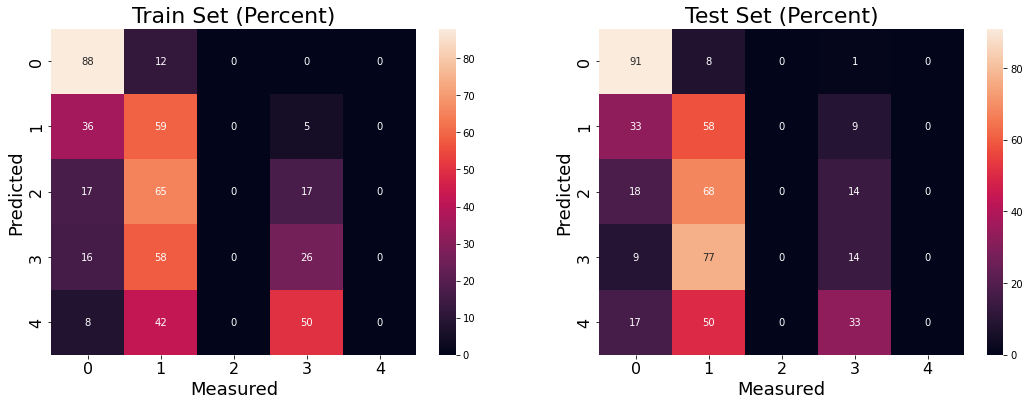

In [29]:
fig, ax = plt.subplots(1,2,figsize= (18,6))
sns.heatmap(conf_train_norm, ax = ax[0], annot=True)
sns.heatmap(conf_test_norm,  ax = ax[1], annot=True)

ax[0].tick_params(axis='both',labelsize=16)
ax[0].set_xlabel('Measured', fontsize= 18)
ax[0].set_ylabel('Predicted', fontsize= 18)
ax[0].set_title('Train Set (Percent)',fontsize= 22)

ax[1].tick_params(axis='both',labelsize=16)
ax[1].set_xlabel('Measured', fontsize= 18)
ax[1].set_ylabel('Predicted', fontsize= 18)
ax[1].set_title('Test Set (Percent)',fontsize= 22);